<a href="https://colab.research.google.com/github/yinon2592/DL_Project_046211/blob/main/section_c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [599]:
# links : https://colab.research.google.com/drive/13dZVYEOMhXhkXWfvSMVM1TTtUDrT6Aeh

In [1]:
from google.colab import drive
# drive.mount('/content/drive/my-drive/project_calculations')
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
file_path = '/content/drive/My Drive/project_calculations/section_c_model_description.txt'

text_content = """
  train size : 8000
  validation size : 2000
  prompt : text = f'\"{txt}\" Q: between positive or negative what was the sentiment of the last text ? A:' + f'{sentiment}'
  total_epochs = 2
  model type: 'gpt2-large'
"""

with open(file_path, 'w') as file:
    file.write(text_content)

In [601]:
# !pip install transformers
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
# % matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel, GPT2Model
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk

In [602]:
### Prepare data
import os
import pandas as pd
from torch.utils.data import Dataset
import re
import torch
# Step 1: Dataset Preparation
# Step 2: Data Preprocessing

# load section_c data (data already cleaned)
section_c_data_path = '/content/drive/My Drive/project_dataset/section_c_data.csv'
df = pd.read_csv(section_c_data_path)
df.dropna(how='any', inplace=True)

# Create a new line with text and label
new_line = {'text': 'I love you', 'label': 1}
# Append the new line to the DataFrame
df = df.append(new_line, ignore_index=True)
# Create a new line with text and label
new_line = {'text': 'I hate you', 'label': 0}
# Append the new line to the DataFrame
df = df.append(new_line, ignore_index=True)

df = df.tail(10_000) # !!! to update df num of samples if needed !!!
print("dataset size is ", df.shape[0])
print(df.label.value_counts())
print(df.tail(5), "\n")



dataset size is  10000
0    5089
1    4911
Name: label, dtype: int64
        label                                   text
532302      0               last free travel at ap 1
532303      0  im starting my many hours of work now
532304      0                 i rather average 32370
532305      1                             I love you
532306      0                             I hate you 



<ipython-input-602-eae4ac7ff48e>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_line, ignore_index=True)
<ipython-input-602-eae4ac7ff48e>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_line, ignore_index=True)


In [603]:
# Load the GPT tokenizer.
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2') #gpt2-medium
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-large')
tokenizer.padding_side = "left" # Very Important
tokenizer.bos_token='<|startoftext|>'
tokenizer.eos_token='<|endoftext|>'
tokenizer.pad_token='<|pad|>'

In [604]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|endoftext|> token has the id 50256
The end of sequence token <|endoftext|> has the id 50256
The padding token <|endoftext|> has the id 50256


In [605]:
batch_size = 2

In [606]:
# class GPT2Dataset(Dataset):

#   def __init__(self, txt_list, labels, tokenizer, gpt2_type="gpt2", max_length=768):

#     self.tokenizer = tokenizer
#     self.input_ids = []
#     self.attn_masks = []

#     for txt, sentiment in zip(txt_list, labels):
#       sentiment = "positive" if sentiment == 1 else "negative"
#       encodings_dict = tokenizer('<|startoftext|> Q: what is the sentiment of the next sentence:\n'+ txt + f"\nA: the sentence is {sentiment}. " + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

#       self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
#       self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

#   def __len__(self):
#     return len(self.input_ids)

#   def __getitem__(self, idx):
#     return self.input_ids[idx], self.attn_masks[idx]


class GPT2Dataset(Dataset):
    def __init__(self, txt_list, labels, tokenizer, gpt2_type="gpt2", max_length=768):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []
        self.labels = []

        for txt, sentiment in zip(txt_list, labels):
            sentiment_text = "positive" if sentiment == 1 else "negative"
            max_length = 150
            # truncated the txt
            txt = txt[:max_length]
            # input_text = '<|startoftext|>' + 'Q: what is the sentiment of the next text: ' + "\"" + txt +  "\"" + f" A: the text sentiment is {sentiment_text}. " + '<|endoftext|>'
            # question = '<|startoftext|>' + "\"" + txt +  "\"" + ' Q: the previous quoted text was positive or negative ?' + f" A: {sentiment_text}" + '<|endoftext|>'
            # txt + f" Q: was the previous text positive or negative: A: {sentiment_text}"
            # input_text = '<|startoftext|>' + txt + f" Q: was the previous text positive or negative: A: {sentiment_text}" + ' <|endoftext|>'
            # input_text = '<|startoftext|>' + "\"" + txt +  "\"" + f"the classification of the previous text sentiment is {sentiment_text}" + '<|endoftext|>'
            # input_text = '<|startoftext|>' + "text = " + "\"" + txt +  "\"" + " text sentiment = " + f"{sentiment_text}" + '<|endoftext|>'

            encodings_dict = self.tokenizer.encode_plus(f'\"{txt}\" Q: between positive or negative what was the sentiment of the last text ? A:',
                                                   text_pair=f'{sentiment}',
                                                   padding='max_length',
                                                   truncation=True,
                                                   max_length=max_length,
                                                   return_tensors='pt')


            # # Tokenize input text
            # encodings_dict = tokenizer(input_text, truncation=True, max_length=max_length, padding="max_length")

            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))


    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]


In [607]:
bios = df.text.copy() #just use the main bio text in this example
bios

# dataset = GPT2Dataset(bios, tokenizer, max_length=768)
# print(len(dataset))
# train_size = int(len(dataset) * 0.8)  # 80% for training
# print("train_size is ", train_size)
# val_size = len(dataset) - train_size  # remaining for validation
# print("val_size is ", val_size)

# train_dataset = dataset[:train_size]  # First train_size rows for training
# val_dataset = dataset[train_size:train_size+val_size]  # Remaining val_size rows for validation


from sklearn.model_selection import train_test_split

dataset = GPT2Dataset(bios, df.label.copy(), tokenizer, max_length=768)

# Split into training and validation sets
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

train_size = len(train_dataset)
val_size = len(val_dataset)

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

<ipython-input-606-3b46ac2ca372>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
<ipython-input-606-3b46ac2ca372>:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))


8,000 training samples
2,000 validation samples


In [608]:
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [609]:
# I'm not really doing anything with the config buheret
# configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)
configuration = GPT2Config.from_pretrained('gpt2-large', output_hidden_states=False)

# instantiate the model
# model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model = GPT2LMHeadModel.from_pretrained('gpt2-large', output_hidden_states=False)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
# device = torch.device("cuda")
# model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [610]:
# some parameters I cooked up that work reasonably well

epochs = 2  # !!! to update df num of epochs if needed !!!
learning_rate = 5e-6
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [611]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [612]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [613]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [614]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

best_val_loss = float('inf')

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        # outputs = model(  b_input_ids,
        #                   labels=b_labels,
        #                   attention_mask = b_masks,
        #                   # token_type_ids=None
        #                 )
        outputs = model(  input_ids = b_input_ids,
                          attention_mask = b_masks)


        # loss = outputs[0]
        loss = outputs[0].mean()
        batch_loss = loss.item()

        # batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    # top_k=50,
                                    max_length = 1,
                                    # top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0
    prediction_labels = []
    true_labels = []
    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        # b_input_ids = batch[0].to(device)
        # b_labels = batch[1].to(device)
        # b_masks = batch[2].to(device)

        with torch.no_grad():

            # outputs  = model(b_input_ids,
            #                token_type_ids=None,
            #                  attention_mask = b_masks,
            #                 labels=b_labels)

            outputs  = model(b_input_ids,
                           token_type_ids=None,
                             attention_mask = b_masks)


            loss = outputs[0].mean()
        batch_loss = loss.item()
        total_eval_loss += batch_loss
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    if avg_val_loss <= best_val_loss:
      best_val_loss = avg_val_loss
      print(" current best val_acc is ", best_val_loss)
      torch.save(model.state_dict(), '/content/drive/My Drive/project_calculations/section_c_generative_model.pth')

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch   100  of  4,000. Loss: -25.532787322998047.   Elapsed: 0:00:18.
0:  bipartisan vote


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch   200  of  4,000. Loss: -29.171144485473633.   Elapsed: 0:00:36.
0:  increasing damage


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch   300  of  4,000. Loss: -30.48090934753418.   Elapsed: 0:00:53.
0: day.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch   400  of  4,000. Loss: -31.595130920410156.   Elapsed: 0:01:11.
0:  Hang over


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch   500  of  4,000. Loss: -32.60003662109375.   Elapsed: 0:01:29.
0:  foods that


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch   600  of  4,000. Loss: -33.51179885864258.   Elapsed: 0:01:47.
0:  trail which


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch   700  of  4,000. Loss: -34.41059494018555.   Elapsed: 0:02:05.
0: intend"


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch   800  of  4,000. Loss: -35.281494140625.   Elapsed: 0:02:22.
0:  surround.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch   900  of  4,000. Loss: -36.149658203125.   Elapsed: 0:02:40.
0:  reflex for


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 1,000  of  4,000. Loss: -36.979896545410156.   Elapsed: 0:02:58.
0:  display the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 1,100  of  4,000. Loss: -37.825260162353516.   Elapsed: 0:03:15.
0:  pastor's


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 1,200  of  4,000. Loss: -38.6727409362793.   Elapsed: 0:03:33.
0:  illicit for


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 1,300  of  4,000. Loss: -39.458831787109375.   Elapsed: 0:03:51.
0:  Liberation is


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 1,400  of  4,000. Loss: -40.2701530456543.   Elapsed: 0:04:09.
0:  Nam on


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 1,500  of  4,000. Loss: -41.053401947021484.   Elapsed: 0:04:26.
0: ION:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 1,600  of  4,000. Loss: -41.8348503112793.   Elapsed: 0:04:44.
0:  glimpse in


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 1,700  of  4,000. Loss: -42.613624572753906.   Elapsed: 0:05:02.
0:  Laureat


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 1,800  of  4,000. Loss: -43.385658264160156.   Elapsed: 0:05:20.
0: ism and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 1,900  of  4,000. Loss: -44.136138916015625.   Elapsed: 0:05:38.
0: oun by


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 2,000  of  4,000. Loss: -44.85908889770508.   Elapsed: 0:05:55.
0:  election and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 2,100  of  4,000. Loss: -45.58262252807617.   Elapsed: 0:06:13.
0:  crazy a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 2,200  of  4,000. Loss: -46.28980255126953.   Elapsed: 0:06:31.
0:  benchs


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 2,300  of  4,000. Loss: -46.988128662109375.   Elapsed: 0:06:49.
0:  incorporated the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 2,400  of  4,000. Loss: -47.67226791381836.   Elapsed: 0:07:06.
0: Peter,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 2,500  of  4,000. Loss: -48.34023666381836.   Elapsed: 0:07:24.
0: uringly


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 2,600  of  4,000. Loss: -48.993324279785156.   Elapsed: 0:07:42.
0:  reproductive and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 2,700  of  4,000. Loss: -49.63886642456055.   Elapsed: 0:08:00.
0:  zone in


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 2,800  of  4,000. Loss: -50.27234649658203.   Elapsed: 0:08:17.
0:  commits will


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 2,900  of  4,000. Loss: -50.89188766479492.   Elapsed: 0:08:35.
0:  irony and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 3,000  of  4,000. Loss: -51.49272918701172.   Elapsed: 0:08:53.
0:  Sah:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 3,100  of  4,000. Loss: -52.09133529663086.   Elapsed: 0:09:11.
0:  Bryan and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 3,200  of  4,000. Loss: -52.679710388183594.   Elapsed: 0:09:28.
0:  spirits who


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 3,300  of  4,000. Loss: -53.2459602355957.   Elapsed: 0:09:46.
0:  sees the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 3,400  of  4,000. Loss: -53.80069351196289.   Elapsed: 0:10:04.
0:  hungry for


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 3,500  of  4,000. Loss: -54.34501266479492.   Elapsed: 0:10:21.
0:  PT in


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 3,600  of  4,000. Loss: -54.88267135620117.   Elapsed: 0:10:39.
0: ün


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 3,700  of  4,000. Loss: -55.4044075012207.   Elapsed: 0:10:57.
0: rucely


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 3,800  of  4,000. Loss: -55.921974182128906.   Elapsed: 0:11:15.
0:  derivatives on


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 3,900  of  4,000. Loss: -56.41462326049805.   Elapsed: 0:11:33.
0: :

  Average training loss: -43.67
  Training epoch took: 0:11:50

Running Validation...
 current best val_acc is  -57.380665481567384
  Validation Loss: -57.38
  Validation took: 0:00:57

======== Epoch 2 / 2 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch   100  of  4,000. Loss: -57.37992477416992.   Elapsed: 0:00:18.
0:  remembering the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch   200  of  4,000. Loss: -57.83955383300781.   Elapsed: 0:00:36.
0:  Sources:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch   300  of  4,000. Loss: -58.29726791381836.   Elapsed: 0:00:54.
0: ems and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch   400  of  4,000. Loss: -58.74314880371094.   Elapsed: 0:01:12.
0: tzm


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch   500  of  4,000. Loss: -59.159725189208984.   Elapsed: 0:01:30.
0: matic and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch   600  of  4,000. Loss: -59.587608337402344.   Elapsed: 0:01:47.
0:  syndi


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch   700  of  4,000. Loss: -59.98302459716797.   Elapsed: 0:02:05.
0:  gamest


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch   800  of  4,000. Loss: -60.38078689575195.   Elapsed: 0:02:23.
0:  injury at


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch   900  of  4,000. Loss: -60.76305389404297.   Elapsed: 0:02:41.
0: azao


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 1,000  of  4,000. Loss: -61.136375427246094.   Elapsed: 0:02:58.
0:  membrane and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 1,100  of  4,000. Loss: -61.49033737182617.   Elapsed: 0:03:16.
0: ijing and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 1,200  of  4,000. Loss: -61.82658767700195.   Elapsed: 0:03:34.
0:  casting


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 1,300  of  4,000. Loss: -62.172119140625.   Elapsed: 0:03:52.
0:  purchee


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 1,400  of  4,000. Loss: -62.489925384521484.   Elapsed: 0:04:09.
0:  shoulders and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 1,500  of  4,000. Loss: -62.80255126953125.   Elapsed: 0:04:27.
0:  built in


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 1,600  of  4,000. Loss: -63.096893310546875.   Elapsed: 0:04:45.
0:  openly put


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 1,700  of  4,000. Loss: -63.387969970703125.   Elapsed: 0:05:02.
0:  halted to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 1,800  of  4,000. Loss: -63.66062927246094.   Elapsed: 0:05:20.
0:  Niko


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 1,900  of  4,000. Loss: -63.91416931152344.   Elapsed: 0:05:38.
0:  tin and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 2,000  of  4,000. Loss: -64.17058563232422.   Elapsed: 0:05:56.
0:  clinical and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 2,100  of  4,000. Loss: -64.40705871582031.   Elapsed: 0:06:13.
0: lections"


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 2,200  of  4,000. Loss: -64.63316345214844.   Elapsed: 0:06:31.
0: els and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 2,300  of  4,000. Loss: -64.84575653076172.   Elapsed: 0:06:49.
0: lab can


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 2,400  of  4,000. Loss: -65.0422592163086.   Elapsed: 0:07:07.
0:  triple the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 2,500  of  4,000. Loss: -65.23588562011719.   Elapsed: 0:07:24.
0: 220s


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 2,600  of  4,000. Loss: -65.41343688964844.   Elapsed: 0:07:42.
0:  See no


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 2,700  of  4,000. Loss: -65.57115936279297.   Elapsed: 0:08:00.
0: @@:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 2,800  of  4,000. Loss: -65.7311019897461.   Elapsed: 0:08:18.
0:  host from


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 2,900  of  4,000. Loss: -65.86400604248047.   Elapsed: 0:08:35.
0: role and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 3,000  of  4,000. Loss: -65.99971771240234.   Elapsed: 0:08:53.
0: iacs


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 3,100  of  4,000. Loss: -66.10763549804688.   Elapsed: 0:09:11.
0:  LD:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 3,200  of  4,000. Loss: -66.21521759033203.   Elapsed: 0:09:29.
0:  Listen:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 3,300  of  4,000. Loss: -66.30842590332031.   Elapsed: 0:09:47.
0:  dyx


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 3,400  of  4,000. Loss: -66.38451385498047.   Elapsed: 0:10:04.
0:  Domestic is


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 3,500  of  4,000. Loss: -66.45590209960938.   Elapsed: 0:10:22.
0:  beneficiaries have


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 3,600  of  4,000. Loss: -66.51478576660156.   Elapsed: 0:10:40.
0:  Title to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 3,700  of  4,000. Loss: -66.55195617675781.   Elapsed: 0:10:58.
0:  μs


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 3,800  of  4,000. Loss: -66.58372497558594.   Elapsed: 0:11:15.
0:  selling so


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


  Batch 3,900  of  4,000. Loss: -66.60218048095703.   Elapsed: 0:11:33.
0:  migrant:

  Average training loss: -63.36
  Training epoch took: 0:11:51

Running Validation...
 current best val_acc is  -67.00326395416259
  Validation Loss: -67.00
  Validation took: 0:01:00

Training complete!
Total training took 0:25:38 (h:mm:ss)


In [615]:
# # Display floats with two decimal places.
# pd.set_option('precision', 2)

# Set the precision option
pd.set_option('display.float_format', '{:.2f}'.format)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,-43.67,-57.38,0:11:50,0:00:57
2,-63.36,-67.00,0:11:51,0:01:00


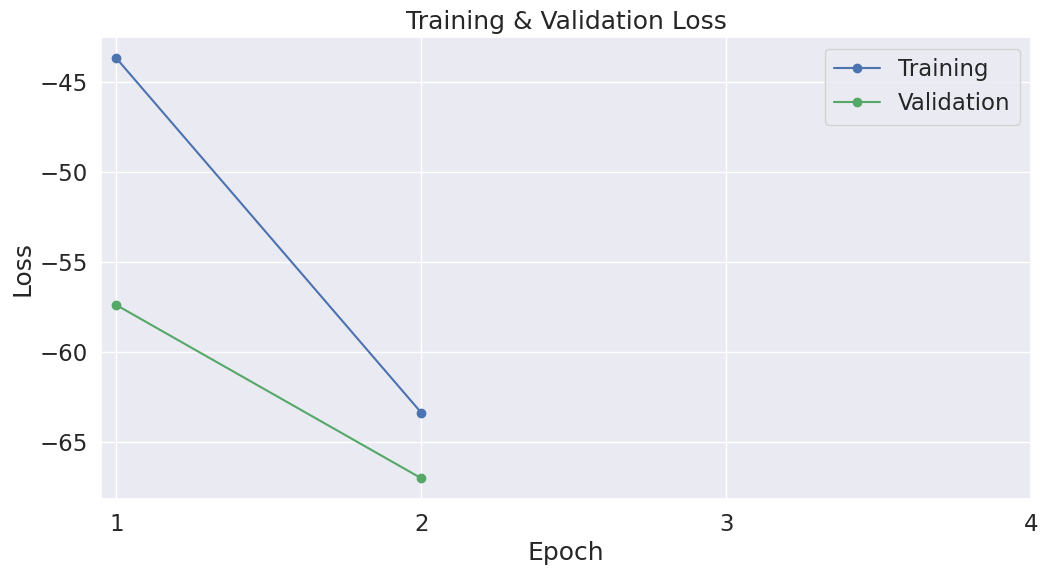

In [616]:
pd.DataFrame.from_dict(df_stats).to_csv('/content/drive/My Drive/project_calculations/section_c_all_loss.csv', index=False)

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [617]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 436 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50257, 1280)
transformer.wpe.weight                                  (1024, 1280)

==== First Transformer ====

transformer.h.0.ln_1.weight                                  (1280,)
transformer.h.0.ln_1.bias                                    (1280,)
transformer.h.0.attn.c_attn.weight                      (1280, 3840)
transformer.h.0.attn.c_attn.bias                             (3840,)
transformer.h.0.attn.c_proj.weight                      (1280, 1280)
transformer.h.0.attn.c_proj.bias                             (1280,)
transformer.h.0.ln_2.weight                                  (1280,)
transformer.h.0.ln_2.bias                                    (1280,)
transformer.h.0.mlp.c_fc.weight                         (1280, 5120)
transformer.h.0.mlp.c_fc.bias                                (5120,)
transformer.h.0.mlp.c_proj.weight                       (5120

In [618]:
# short sanity check

model.eval()
def generate_response(question):
    # Encode the question
    input_ids = tokenizer.encode(question, return_tensors="pt").to(device)

    # Generate the response
    output = model.generate(
        input_ids,
        max_length=100,
        num_return_sequences=1,
        attention_mask=input_ids.ne(tokenizer.pad_token_id).to(device),
        pad_token_id=tokenizer.eos_token_id
    )

    # Decode and return the generated response
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    return response


# Example usage
txt = "i love you"
# question = '<|startoftext|> answer in one word\nQ: what is the sentiment of the next sentence:\n'+ txt + f"\nA: the sentence is " + '<|endoftext|>'
# question = txt + '\n Q: was the previous text positive or negative: ' + "\nA:"
# question = "text = " + "\"" + txt +  "\"" + "text sentiment = "
# input_text = '<|startoftext|>' + 'Q: what is the sentiment of the next text: ' + "\"" + txt +  "\"" + f" A: the text sentiment is {sentiment_text}. " + '<|endoftext|>'
# question =  "\"" + txt +  "\"" + ' Q: positive or negative: ' + " A: "
      #  encodings_dict = self.tokenizer.encode_plus(f'Q: what is the sentiment of the next text: \"{txt}\"\nA:',

question = f'\"{txt}\" Q: between positive or negative what was the sentiment of the last text ? A:'
response = generate_response(question)
# response= response.split()[-1]
print(f"{question}\n{response}")

print("\n")

# tokenizer.padding_side = "left" # Very Important
# tokenizer.bos_token='<|startoftext|>'
# tokenizer.eos_token='<|endoftext|>'
# tokenizer.pad_token='<|pad|>'
# input_text = '<|startoftext|>' + txt + '\n Q: was the previous text positive or negative:\n' + f"\nA: {sentiment_text}. " + ' <|endoftext|>'

txt = "I hate you"
# question = txt + ' Q: was the previous text positive or negative: ' + " A: "
question = f'Q: between positive or negative what is the sentiment of the next text: \"{txt}\" A:'
response = generate_response(question)
# response = response.split()[-1]
print(f"{question}\n{response}")

"i love you" Q: between positive or negative what was the sentiment of the last text ? A:
"i love you" Q: between positive or negative what was the sentiment of the last text? A: the last text was a text that was a text that was a text that was a text that was a text that was a and a and a and a and a and a and a and a and a and a and a and a and a and a and a and a and a and a and a and a and a and a and a and a and a and a and a and


Q: between positive or negative what is the sentiment of the next text: "I hate you" A:
Q: between positive or negative what is the sentiment of the next text: "I hate you" A: the text is a negative and the text is a positive and the text is a negative and the text is a positive and the text is a negative and the text is a positive and the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
